In [1]:
# !pip install matplotlib

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
training_data = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=ToTensor()
)

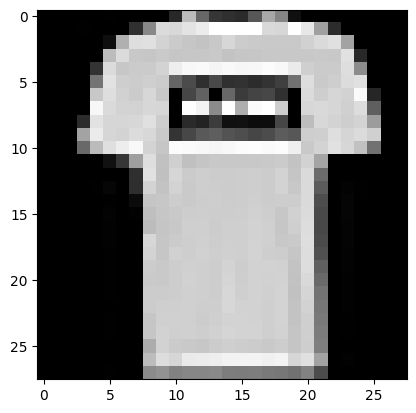

In [3]:
show_img = training_data[1][0].numpy().reshape(28, 28)
plt.imshow(show_img, cmap="gray")

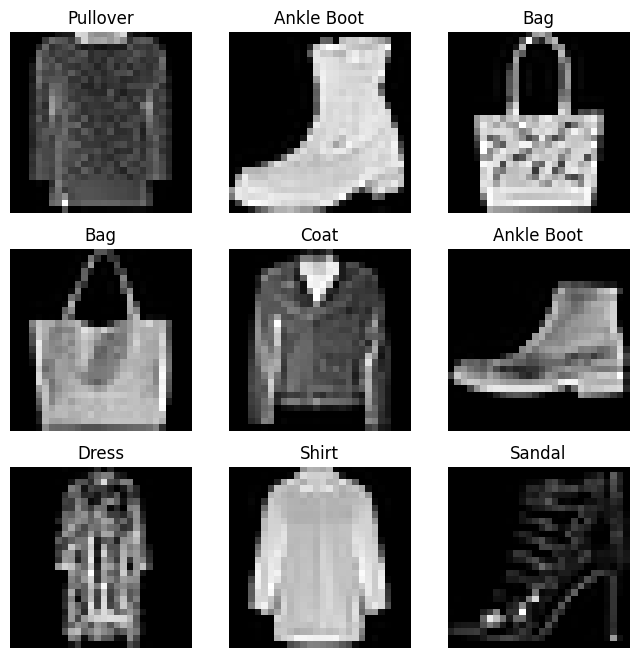

In [4]:
# show 9 random images
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Create data loaders

In [5]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


Create Neural Network class

In [7]:
class LogisticRegression(nn.Module):

    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(28 * 28, 10)

    def forward(self, x):
        x = self.flatten(x)
        y_predicted = self.linear(x)
        return y_predicted


model = LogisticRegression().to(device)
print(model)

LogisticRegression(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)  # lr - learning rate

Create training function

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    avg_loss = 0
    correct = 0
    for batch_nr, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        avg_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch_nr % 100 == 0:
            loss, current = loss.item(), batch_nr * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    avg_loss /= num_batches
    correct /= size
    return avg_loss, correct

Create test function

In [10]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    accuracy = 100 * correct
    print(f"Test Error: \n Accuracy: {(accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Training the model

In [11]:
train_losses = []
train_accuracies = []
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_loss, avg_acc = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.append(avg_loss)
    train_accuracies.append(avg_acc)
    test(test_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 2.308214  [    0/60000]
loss: 2.106625  [ 6400/60000]
loss: 2.012680  [12800/60000]
loss: 1.850518  [19200/60000]
loss: 1.731732  [25600/60000]
loss: 1.687190  [32000/60000]
loss: 1.644349  [38400/60000]
loss: 1.499827  [44800/60000]
loss: 1.417879  [51200/60000]
loss: 1.312862  [57600/60000]
Test Error: 
 Accuracy: 65.4%, Avg loss: 1.364171 

Epoch 2
-------------------------------
loss: 1.283927  [    0/60000]
loss: 1.363324  [ 6400/60000]
loss: 1.320983  [12800/60000]
loss: 1.275721  [19200/60000]
loss: 1.251663  [25600/60000]
loss: 1.037174  [32000/60000]
loss: 1.210189  [38400/60000]
loss: 1.077911  [44800/60000]
loss: 1.160375  [51200/60000]
loss: 1.098104  [57600/60000]
Test Error: 
 Accuracy: 66.9%, Avg loss: 1.102369 

Epoch 3
-------------------------------
loss: 1.090788  [    0/60000]
loss: 1.010805  [ 6400/60000]
loss: 1.005624  [12800/60000]
loss: 1.006820  [19200/60000]
loss: 0.965906  [25600/60000]
loss: 1.079326  [32000/600

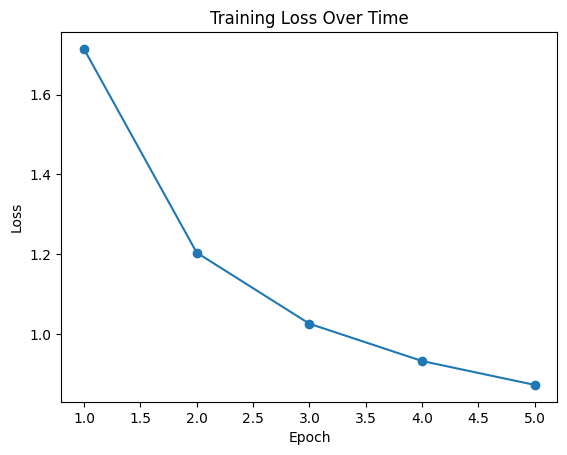

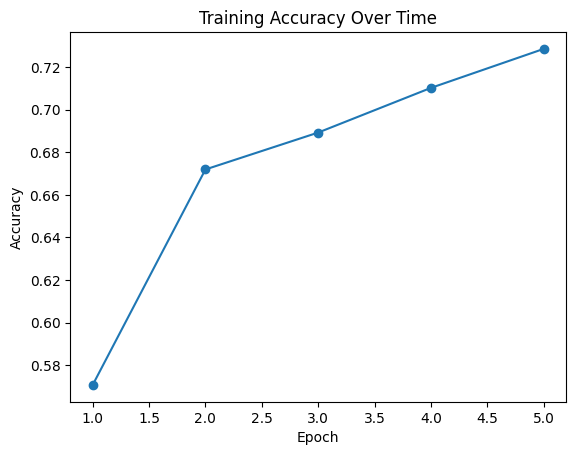

In [12]:
# Plot the loss over time
plt.plot(range(1, epochs + 1), train_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.show()

# Plot the accuracy over time
plt.plot(range(1, epochs + 1), train_accuracies, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Time")
plt.show()

Testing the model

In [13]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
model.eval()
for i in range(10):
    x, y = test_data[i][0], test_data[i][1]
    with torch.no_grad():
        pred = model(x)
        predicted = classes[pred[0].argmax(0)]
        actual = classes[y]
        print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
Predicted: "Pullover", Actual: "Pullover"
Predicted: "Trouser", Actual: "Trouser"
Predicted: "Trouser", Actual: "Trouser"
Predicted: "Shirt", Actual: "Shirt"
Predicted: "Trouser", Actual: "Trouser"
Predicted: "Coat", Actual: "Coat"
Predicted: "Shirt", Actual: "Shirt"
Predicted: "Sneaker", Actual: "Sandal"
Predicted: "Sneaker", Actual: "Sneaker"


In [15]:
total = 0
correct = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f"Accuracy of the network on the 10000 test images: {accuracy}%")

Accuracy of the network on the 10000 test images: 72.4%


## Conclusion

In this notebook, I implemented a logistic regression model using PyTorch to classify images from the FashionMNIST dataset, following the steps. I loaded the dataset and visualized some sample images. I created data loaders for training and testing datasets. I defined a logistic regression model using PyTorch's `nn.Module`. I implemented and executed a training loop to train the model over multiple epochs. I evaluated the model's performance on the test dataset and calculated the accuracy.

The final accuracy of the model on the test dataset was approximately `77.89%`. This demonstrates that the logistic regression model can effectively classify the FashionMNIST images, although there is room for improvement with more complex models or additional training techniques.